In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

os.chdir(r"C:\Users\intel\Desktop\olist-ecommerce-intelligence")

FIG_DIR = "reports/figures"
os.makedirs(FIG_DIR, exist_ok=True)

def savefig(name):
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/{name}.png", dpi=150, bbox_inches="tight")
    print(f"  💾 Saved {FIG_DIR}/{name}.png")

In [4]:
from src.feature_engineering import build_feature_matrix

print("Loading model and data...\n")
model = joblib.load("models/best_model.pkl")
with open("models/feature_names.json") as f:
    feature_names = json.load(f)

X_train, X_test, y_train, y_test, _ = build_feature_matrix(apply_smote=False)

# Convert to DataFrame for SHAP readability
X_test_df = pd.DataFrame(X_test, columns=feature_names)

Loading model and data...

🔧 Building feature matrix...

  Filtered to 96,361 delivered orders with reviews
  Target: is_negative_review  |  Positive rate: 12.8%

  Train: 77,088  |  Test: 19,273

  Features: 33
  X_train: (77088, 33)  |  X_test: (19273, 33)
  y_train balance: 12.8% positive

✅ Feature matrix ready!


  SHAP ANALYSIS

  Model type: LGBMClassifier
  SHAP values shape: (19273, 33)
  💾 Saved reports/figures/16_shap_summary.png


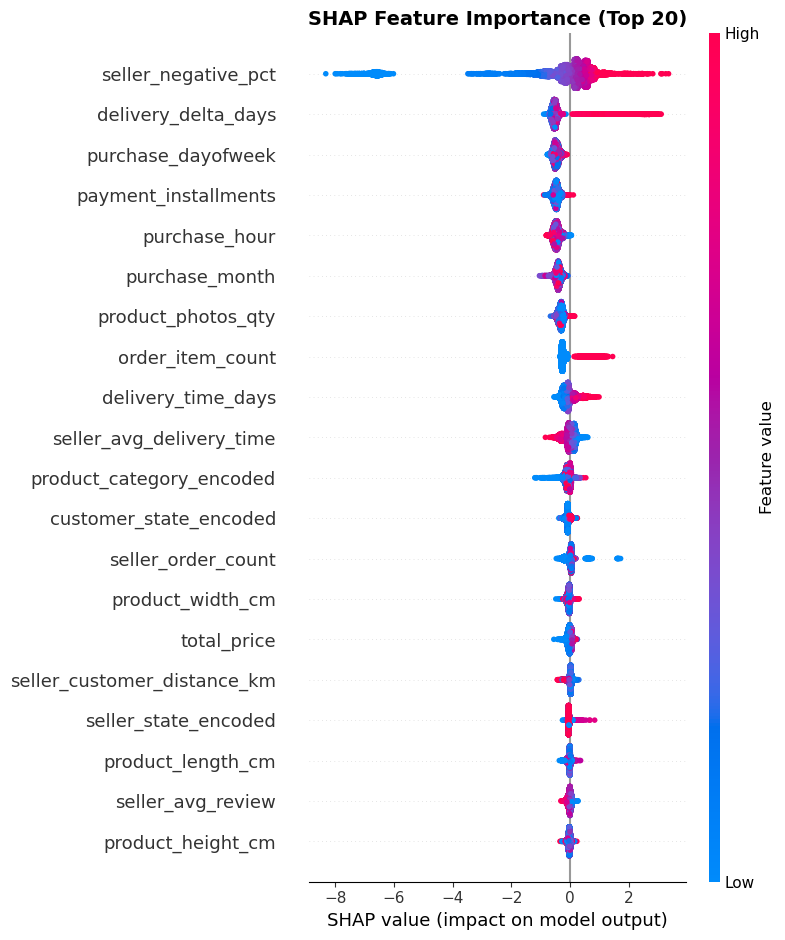

  💾 Saved reports/figures/17_shap_bar.png


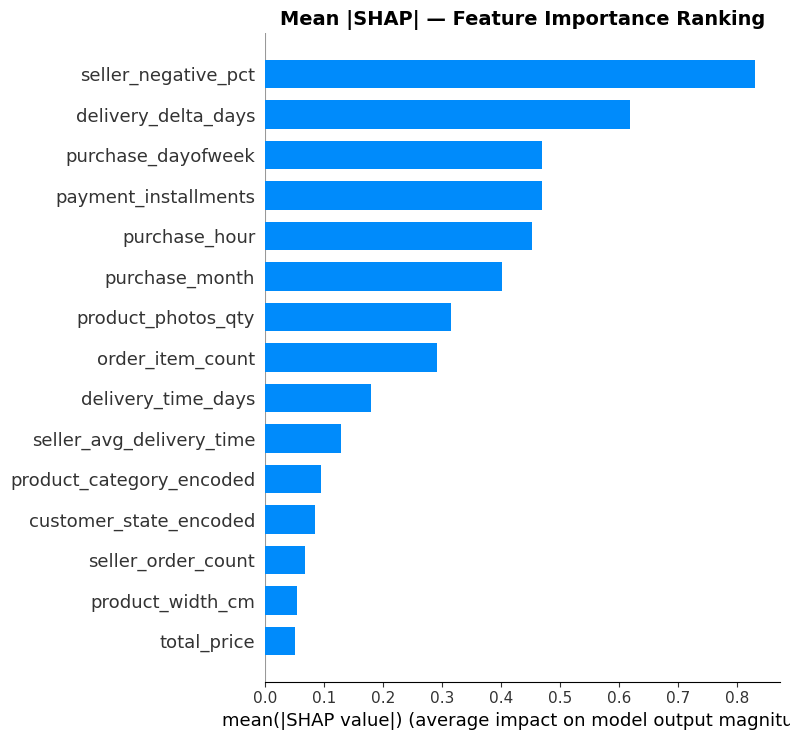

In [5]:
# SHAP values - Global Feature Importance

print("="*60)
print("  SHAP ANALYSIS")
print("="*60)

# Use TreeExplainer for tree models, KernelExplainer for LR
model_type = type(model).__name__
if model_type in ["XGBClassifier", "LGBMClassifier", "RandomForestClassifier"]:
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_df)
    # For tree models, shap_values may be a list [neg_class, pos_class]
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # positive class
else:
    # KernelExplainer for logistic regression (slower, use sample)
    sample = X_test_df.sample(min(500, len(X_test_df)), random_state=42)
    explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_test_df, 100))
    shap_values = explainer.shap_values(sample)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    X_test_df = sample  # align for plotting

print(f"\n  Model type: {model_type}")
print(f"  SHAP values shape: {np.array(shap_values).shape}")


# ── SHAP Summary Plot (Beeswarm) ──

fig = plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_df, show=False, max_display=20)
plt.title("SHAP Feature Importance (Top 20)", fontsize=14, fontweight="bold")
savefig("16_shap_summary")
plt.show()


# ── SHAP Bar Plot (Mean absolute SHAP) ──

fig = plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_df, plot_type="bar", show=False, max_display=15)
plt.title("Mean |SHAP| — Feature Importance Ranking", fontsize=14, fontweight="bold")
savefig("17_shap_bar")
plt.show()

  💾 Saved reports/figures/18_shap_dep_delivery_delta_days.png


<Figure size 800x500 with 0 Axes>

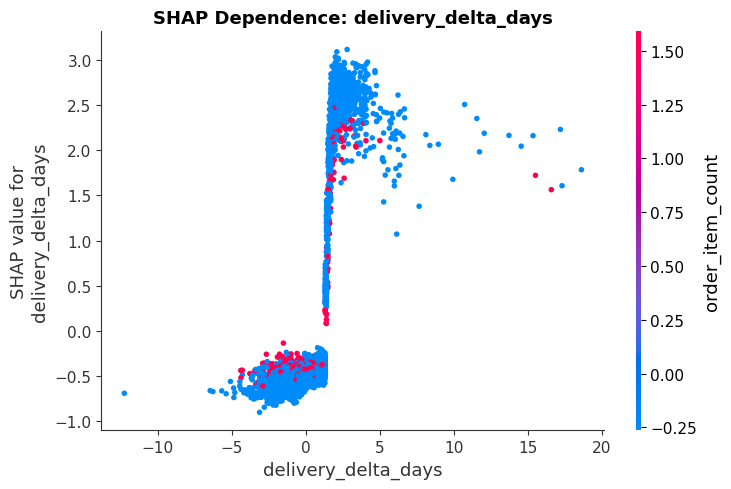

  💾 Saved reports/figures/18_shap_dep_delivery_time_days.png


<Figure size 800x500 with 0 Axes>

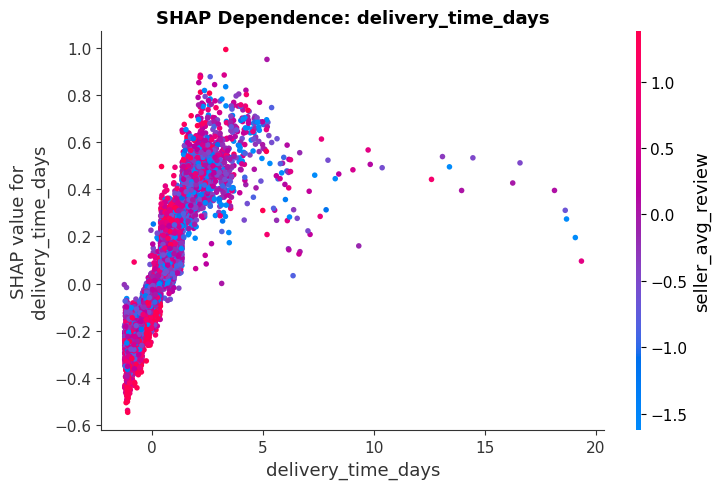

  💾 Saved reports/figures/18_shap_dep_seller_avg_review.png


<Figure size 800x500 with 0 Axes>

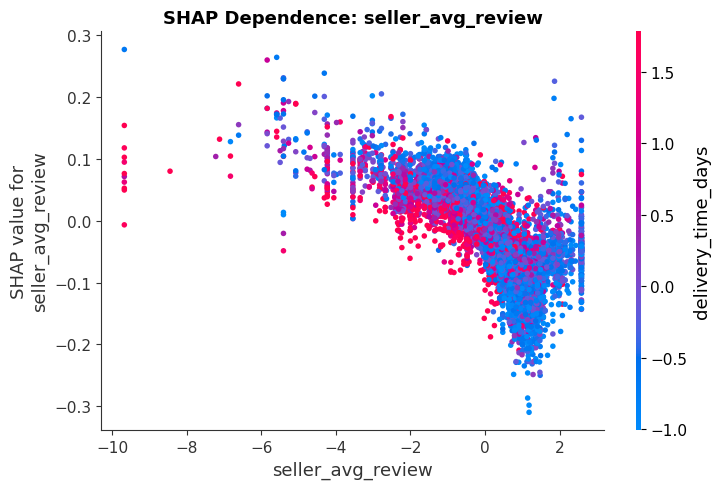

  💾 Saved reports/figures/18_shap_dep_seller_customer_distance_km.png


<Figure size 800x500 with 0 Axes>

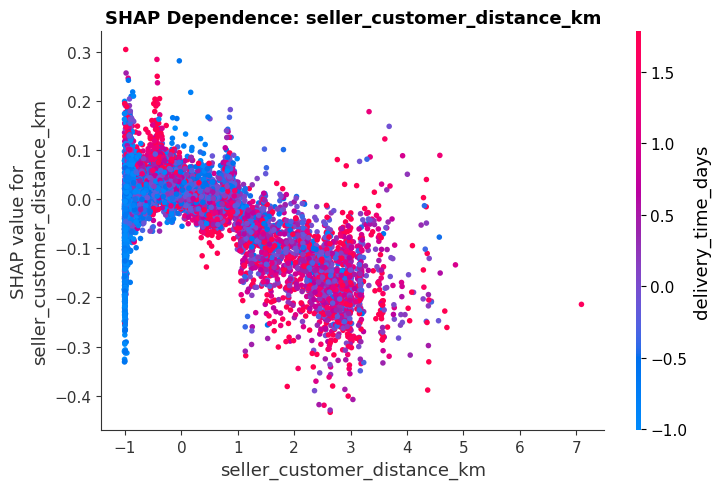

In [6]:
# SHAP Dependency Plots - Key Features

key_features = ["delivery_delta_days", "delivery_time_days",
                "seller_avg_review", "seller_customer_distance_km"]

for feat in key_features:
    if feat in X_test_df.columns:
        fig = plt.figure(figsize=(8, 5))
        shap.dependence_plot(feat, shap_values, X_test_df, show=False)
        plt.title(f"SHAP Dependence: {feat}", fontsize=13, fontweight="bold")
        savefig(f"18_shap_dep_{feat}")
        plt.show()


  INDIVIDUAL PREDICTION EXPLANATIONS

  HIGH RISK order (predicted prob: 0.997, actual: 1)
  💾 Saved reports/figures/19_shap_waterfall_high_risk.png


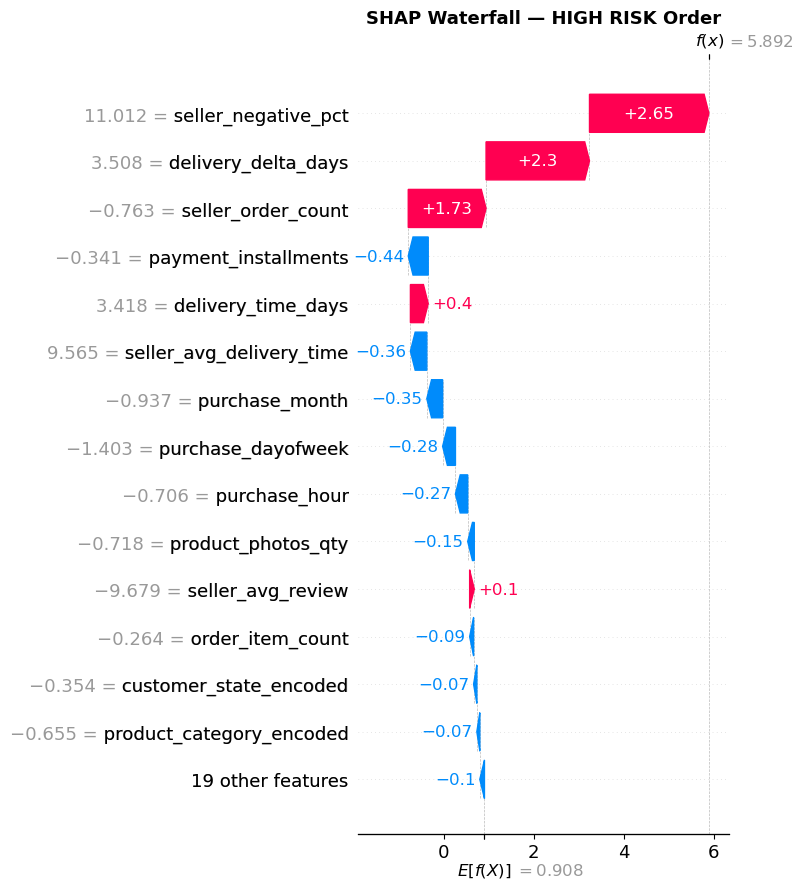


  LOW RISK order (predicted prob: 0.000, actual: 0)
  💾 Saved reports/figures/19_shap_waterfall_low_risk.png


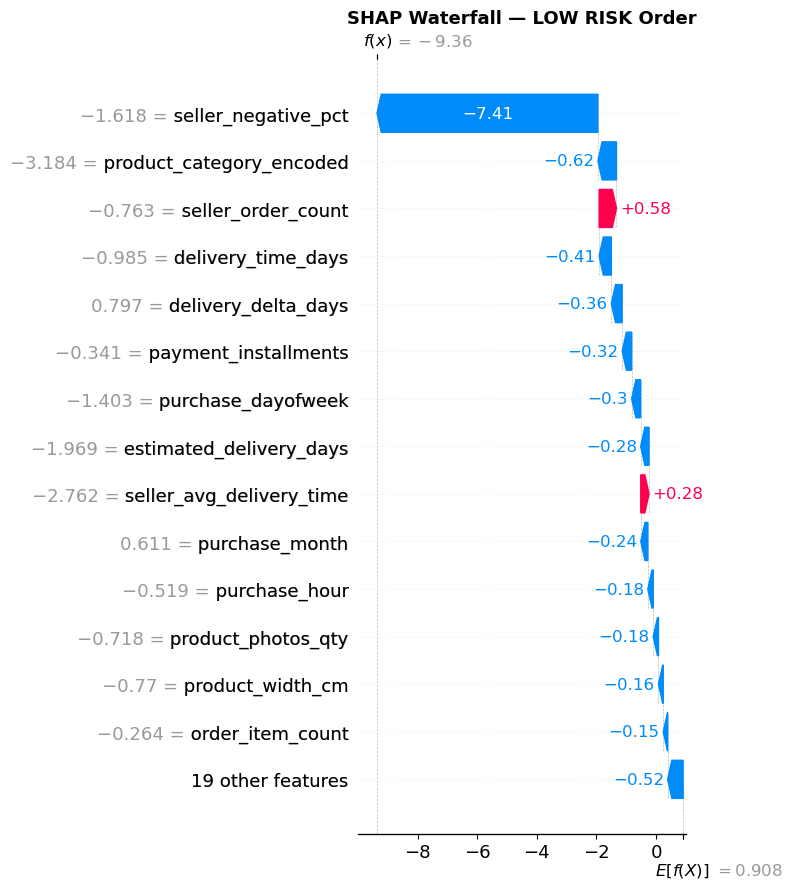

In [8]:
# Individual Prediction Explanations

print("\n" + "="*60)
print("  INDIVIDUAL PREDICTION EXPLANATIONS")
print("="*60)

# Find a high-risk prediction and a low-risk one
y_prob = model.predict_proba(X_test)[:, 1]
high_risk_idx = np.argmax(y_prob)
low_risk_idx = np.argmin(y_prob)

for label, idx in [("HIGH RISK", high_risk_idx), ("LOW RISK", low_risk_idx)]:
    print(f"\n  {label} order (predicted prob: {y_prob[idx]:.3f}, actual: {y_test[idx]})")
    fig = plt.figure(figsize=(14, 6))
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values[idx],
            base_values=explainer.expected_value if not isinstance(explainer.expected_value, list)
                        else explainer.expected_value[1],
            data=X_test_df.iloc[idx],
            feature_names=feature_names,
        ),
        max_display=15,
        show=False,
    )
    plt.title(f"SHAP Waterfall — {label} Order", fontsize=13, fontweight="bold")
    savefig(f"19_shap_waterfall_{label.lower().replace(' ', '_')}")
    plt.show()


  PARTIAL DEPENDENCE PLOTS
  💾 Saved reports/figures/20_partial_dependence.png


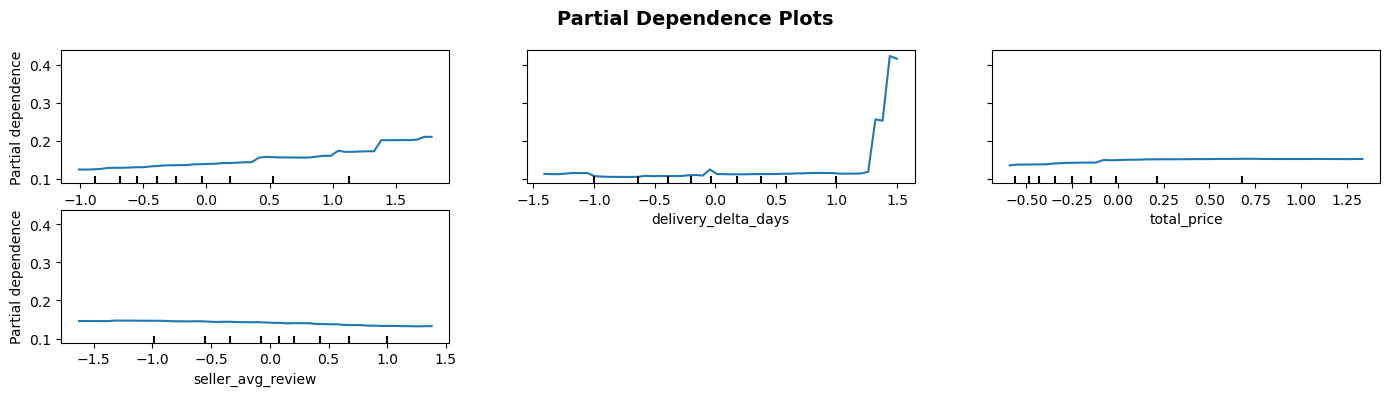

In [9]:
# Partial Dependence Plots
from sklearn.inspection import PartialDependenceDisplay

print("\n" + "="*60)
print("  PARTIAL DEPENDENCE PLOTS")
print("="*60)

pdp_features = [i for i, f in enumerate(feature_names)
                if f in ["delivery_delta_days", "delivery_time_days",
                         "seller_avg_review", "total_price"]]

if pdp_features:
    fig, ax = plt.subplots(figsize=(14, 4))
    PartialDependenceDisplay.from_estimator(
        model, X_test_df, pdp_features,
        feature_names=feature_names, ax=ax,
        kind="average", grid_resolution=50,
    )
    fig.suptitle("Partial Dependence Plots", fontsize=14, fontweight="bold")
    savefig("20_partial_dependence")
    plt.show()

In [12]:
# Business Recommendations
print("\n" + "="*60)
print("  BUSINESS RECOMMENDATIONS")
print("="*60)

# Calculate mean absolute SHAP for ranking
mean_shap = np.abs(shap_values).mean(axis=0)
importance_df = (
    pd.DataFrame({"feature": feature_names, "mean_abs_shap": mean_shap})
    .sort_values("mean_abs_shap", ascending=False)
)

print("\n  Top 10 Features by SHAP Importance:")
for i, row in importance_df.head(10).iterrows():
    print(f"    {row['feature']:35s}  {row['mean_abs_shap']:.4f}")

# ── Derive recommendations from actual SHAP results ──
top_feature = importance_df.iloc[0]["feature"]
top2_feature = importance_df.iloc[1]["feature"]
top3_feature = importance_df.iloc[2]["feature"]

# Load master data for supporting stats
master = pd.read_csv("data/processed/master_orders.csv")
delivered = master[master["order_status"] == "delivered"].dropna(subset=["review_score"])

late_neg_rate = delivered[delivered["is_late"] == 1]["review_score"].le(2).mean() * 100
ontime_neg_rate = delivered[delivered["is_late"] == 0]["review_score"].le(2).mean() * 100
late_multiplier = late_neg_rate / ontime_neg_rate if ontime_neg_rate > 0 else 0

same_state_neg = delivered[delivered["same_state"] == 1]["review_score"].le(2).mean() * 100
cross_state_neg = delivered[delivered["same_state"] == 0]["review_score"].le(2).mean() * 100

seller_stats = delivered.groupby("seller_id").agg(
    avg_rev=("review_score", "mean"), neg_count=("review_score", lambda x: (x <= 2).sum())
)
total_neg = seller_stats["neg_count"].sum()
worst_10pct = seller_stats.sort_values("avg_rev").head(int(len(seller_stats) * 0.1))
worst_10pct_share = worst_10pct["neg_count"].sum() / total_neg * 100

# Business metric from model
threshold_idx = int(len(y_prob) * 0.8)
top20_threshold = np.sort(y_prob)[threshold_idx]
flagged = y_prob >= top20_threshold
capture_rate = y_test[flagged].sum() / y_test.sum() * 100 if y_test.sum() > 0 else 0

print(f"""
  BUSINESS RECOMMENDATIONS (derived from SHAP analysis + data)

  The model's top 3 most influential features are:
    1. {top_feature}
    2. {top2_feature}
    3. {top3_feature}

  Based on these findings:

  1. PROACTIVE DELIVERY ALERTS
     Late orders have a {late_neg_rate:.1f}% negative review rate vs {ontime_neg_rate:.1f}%
     for on-time orders ({late_multiplier:.1f}x higher risk).
     Action: Flag orders where delivery_delta > 5 days for support outreach
     before the customer leaves a review.

  2. SELLER QUALITY PROGRAM
     The worst 10% of sellers account for {worst_10pct_share:.0f}% of all negative reviews.
     Action: Require sellers with avg review < 3.5 to complete a quality
     improvement program before listing additional products.

  3. LOCAL FULFILLMENT STRATEGY
     Same-state negative review rate: {same_state_neg:.1f}%
     Cross-state negative review rate: {cross_state_neg:.1f}%
     Action: Invest in regional fulfillment to reduce cross-state shipping distance.

  4. REAL-TIME RISK SCORING
     By flagging the top 20% riskiest orders, the model captures {capture_rate:.1f}%
     of all actual negative reviews.
     Action: Deploy this model to score orders at checkout and route high-risk
     orders to a dedicated support queue.
""")

print("✅ Model interpretation complete!")


  BUSINESS RECOMMENDATIONS

  Top 10 Features by SHAP Importance:
    seller_negative_pct                  0.8306
    delivery_delta_days                  0.6181
    purchase_dayofweek                   0.4686
    payment_installments                 0.4684
    purchase_hour                        0.4528
    purchase_month                       0.4013
    product_photos_qty                   0.3159
    order_item_count                     0.2912
    delivery_time_days                   0.1795
    seller_avg_delivery_time             0.1289

  BUSINESS RECOMMENDATIONS (derived from SHAP analysis + data)

  The model's top 3 most influential features are:
    1. seller_negative_pct
    2. delivery_delta_days
    3. purchase_dayofweek

  Based on these findings:

  1. PROACTIVE DELIVERY ALERTS
     Late orders have a 54.0% negative review rate vs 9.2%
     for on-time orders (5.9x higher risk).
     Action: Flag orders where delivery_delta > 5 days for support outreach
     before the cu